# Setup

## Libraries

In [1]:
import pandas as pd

## Load the dataset
let's load the dataset and set column `DATE` as the index.

In [2]:
df_ = pd.read_csv('../rawdata/weather-louisville-noaa.csv', index_col = 'DATE', parse_dates = True)

/Users/luca/.pyenv/versions/miniconda3-latest/envs/mobility/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (30,31,33,34,41,42,43,48,49,51,53,69,71,73,75,76,88,89) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Creating a hourly dataset

let's create a variable for storing the hourly features we are interested in keeping.

In [3]:
hourly_features = [ col for col in df_.columns if 'Hourly' in col ]

Of course, we want to `resample` the data:

> resample() is a time-based groupby, followed by a reduction method on each of its groups.
 
Like so:

```
df_hourly = df[hourly_features].resample('1H').mean()
```
However, this does not work if there are invalid values which are not `floats` but `objects`.

In [4]:
df = df_[hourly_features]

Now that we have all `hourly` variables we can rename the features to make it less redundant. **remember that `.columns` is an attribute of the `DataFrame`!**

In [5]:
df.columns

Index(['HourlyAltimeterSetting', 'HourlyDewPointTemperature',
       'HourlyDryBulbTemperature', 'HourlyPrecipitation',
       'HourlyPresentWeatherType', 'HourlyPressureChange',
       'HourlyPressureTendency', 'HourlyRelativeHumidity',
       'HourlySeaLevelPressure', 'HourlySkyConditions',
       'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature',
       'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed'],
      dtype='object')

In [6]:
df.columns = df.columns.str.replace('Hourly', '')

In [7]:
df.columns

Index(['AltimeterSetting', 'DewPointTemperature', 'DryBulbTemperature',
       'Precipitation', 'PresentWeatherType', 'PressureChange',
       'PressureTendency', 'RelativeHumidity', 'SeaLevelPressure',
       'SkyConditions', 'StationPressure', 'Visibility', 'WetBulbTemperature',
       'WindDirection', 'WindGustSpeed', 'WindSpeed'],
      dtype='object')

In [8]:
to_drop = ['AltimeterSetting',
           'PresentWeatherType',
           'PressureTendency',
           'SeaLevelPressure',
           'StationPressure',
           'SkyConditions',
           'WindDirection',
           'WindGustSpeed']

In [9]:
df = df.drop(to_drop, axis = 1)  # specify that axis = 1, that is we are dropping columns

# Data Wrangling

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55438 entries, 2017-01-01 00:56:00 to 2020-11-01 23:59:00
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DewPointTemperature  53972 non-null  object 
 1   DryBulbTemperature   53980 non-null  object 
 2   Precipitation        39079 non-null  object 
 3   PressureChange       22139 non-null  float64
 4   RelativeHumidity     53972 non-null  object 
 5   Visibility           53978 non-null  object 
 6   WetBulbTemperature   53872 non-null  object 
 7   WindSpeed            53969 non-null  float64
dtypes: float64(2), object(6)
memory usage: 3.8+ MB


`PressureChange` and `WindSpeed` are `float64`, so we won't have to look at them!

#### `object` type

> The object data type is a special one. According to the Pandas Cookbook, the object data type is “a catch-all for columns that Pandas doesn’t recognize as any other specific type.” In practice, it often means that all of the values in the column are strings.

There are quite a few problems: `Dtype` is not what we expect for most of the variables. There are several missing values; however, those for `HourlyPrecipitations` make sense: when it does not rain is zero, of course. The same goes for `HourlyPressureChange`. Also, there will also be *invalid values* as well.

> Upon inspection, all of the data types are currently the object dtype, which is roughly analogous to str in native Python. It encapsulates any field that can’t be neatly fit as numerical or categorical data. This makes sense since we’re working with data that is initially a bunch of messy strings.

In [11]:
import numpy as np # because we might need np.NaN

## Visibility

In [12]:
df['Visibility'].value_counts()

10.00    31670
9.94      9187
9.00      1975
8.00      1256
7.00      1197
3.00      1154
4.00       962
6.00       953
5.00       927
2.50       922
2.00       684
8.70       496
7.46       320
1.50       308
1.75       237
6.84       233
1.00       198
5.59       182
4.97       147
3.73       133
0.75       131
0.25       117
1.25       117
2.98       103
2.49        91
0.50        75
1.99        49
0.12        45
0.99        20
1.49        17
2.50V       15
1.74        14
1.24        12
0.00        10
2.00V        7
1.25V        4
1.75V        4
1.00V        2
99.42        2
0.06         1
1.50V        1
Name: Visibility, dtype: int64

In [13]:
df['Visibility'] = df['Visibility'].str.replace('[A-Z$]', '', regex = True).astype('float')

In [14]:
df['Visibility'] = df['Visibility'].replace(99.42, 9.94)

## Relative Humidity

In [15]:
df['RelativeHumidity'].value_counts()

93.0    2174
90.0    1815
87.0    1510
79.0    1465
89.0    1313
        ... 
21         3
23         3
22         3
98.0       2
*          1
Name: RelativeHumidity, Length: 163, dtype: int64

In [16]:
df['RelativeHumidity'] = df['RelativeHumidity'].replace(r'*', np.NaN)

In [17]:
df['RelativeHumidity'] = df['RelativeHumidity'].astype('float')

## Temperatures

Data from `DryBulbTemperature`, `DewPointTemperature`, `WetBulbTemperature`.

In [18]:
temperature = ['DryBulbTemperature', 'DewPointTemperature','WetBulbTemperature']

In [19]:
for col in temperature:
    df[col] = df[col].str.replace(r'[a-z]', '', regex = True)
    df[col] = df[col].replace(r'*', np.NaN)
    df[col] = df[col].astype('float')
    df[col] = (df[col] - 32) * 5/9    

## Precipitations

**ATTENTION!**

Instances of `T` were replaced, but the `type` remained `string`! We have to change it to `float`.

In [20]:
df['Precipitation'] = df['Precipitation'].replace('T', 0.01)

In [21]:
df['Precipitation'] = df['Precipitation'].str.replace('[a-z]', '').astype('float')

In [22]:
df['Precipitation'] = df['Precipitation'] * 254 # transform hundredths of inches to mm

In [23]:
df['Precipitation'].value_counts()

0.00      27846
2.54       1471
5.08        845
7.62        565
10.16       400
          ...  
241.30        1
294.64        1
276.86        1
198.12        1
292.10        1
Name: Precipitation, Length: 111, dtype: int64

## WindSpeed

In [24]:
df.WindSpeed = df.WindSpeed.apply(lambda x : x * 1.609)

# Resampling & Feature Selection

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55438 entries, 2017-01-01 00:56:00 to 2020-11-01 23:59:00
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DewPointTemperature  14088 non-null  float64
 1   DryBulbTemperature   38019 non-null  float64
 2   Precipitation        33798 non-null  float64
 3   PressureChange       22139 non-null  float64
 4   RelativeHumidity     53971 non-null  float64
 5   Visibility           53978 non-null  float64
 6   WetBulbTemperature   6118 non-null   float64
 7   WindSpeed            53969 non-null  float64
dtypes: float64(8)
memory usage: 3.8 MB


In [26]:
hourly = df.resample('1H').mean()

In [27]:
hourly.isnull().sum()

DewPointTemperature    24617
DryBulbTemperature      9793
Precipitation           3122
PressureChange         11488
RelativeHumidity           0
Visibility                 1
WetBulbTemperature     29792
WindSpeed                  5
dtype: int64

There are too few observations for `DewPointTemperature` and `WetBulbTemperature`. However, these measures are a function of `DryBulbTemperature` and `RelativeHumidity`, so the information of these two features is already contained in these two measures. Also, we expect `Precipitation` and `Visibility` to have a greater impact (conditonal on the level of `DryBulbTemperature` as well) on the usage of e-scooters. `PressureChange` variance is so tiny it does not bring any additional information to the analysis.

In [28]:
del hourly['DewPointTemperature']
del hourly['WetBulbTemperature']
del hourly['PressureChange']

# Missing Values

In [29]:
hourly.head()

,DryBulbTemperature,Precipitation,RelativeHumidity,Visibility,WindSpeed
DATE,,,,,
2017-01-01 00:00:00,6.111111,0.0,82.0,10.000,4.8270
2017-01-01 01:00:00,6.111111,0.0,82.0,9.970,2.4135
2017-01-01 02:00:00,5.555556,0.0,79.0,10.000,0.0000
2017-01-01 03:00:00,5.000000,0.0,89.0,6.000,9.6540
2017-01-01 04:00:00,5.000000,0.0,89.0,5.295,4.8270


In [30]:
hourly.isnull().sum()

DryBulbTemperature    9793
Precipitation         3122
RelativeHumidity         0
Visibility               1
WindSpeed                5
dtype: int64

In [31]:
interpolate = ['Precipitation', 'WindSpeed', 'Visibility']

for col in interpolate:
    hourly[col] = hourly[col].interpolate()

In [32]:
import matplotlib.pyplot as plt

In [33]:
len(hourly.columns)

5

In [34]:
hourly.rename(columns={'DryBulbTemperature' : 'Temperature', 'RelativeHumidity': 'Humidity'}, inplace = True)
hourly.columns

Index(['Temperature', 'Precipitation', 'Humidity', 'Visibility', 'WindSpeed'], dtype='object')

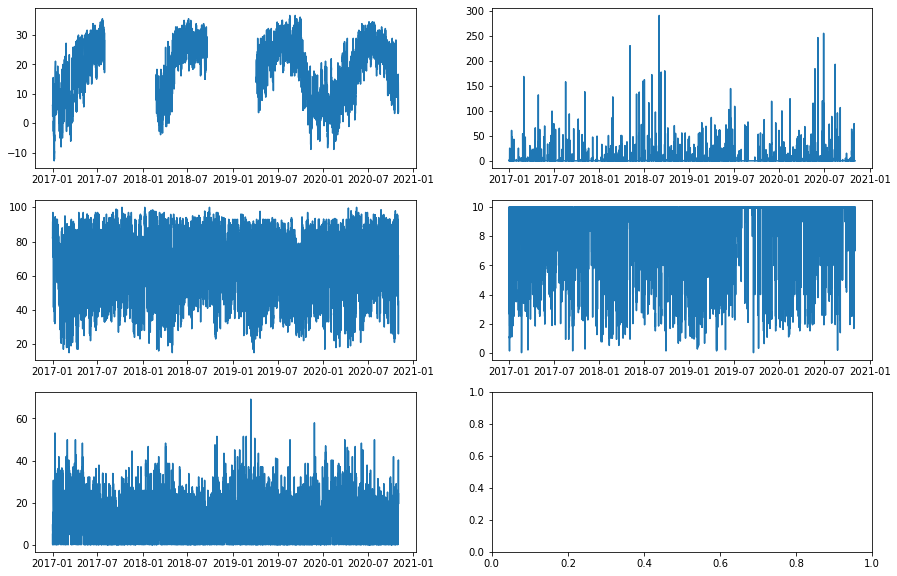

In [35]:
fig, ax = plt.subplots(3, 2, figsize = (15,10))

ax.flat[0].plot(hourly.index, hourly['Temperature'])
ax.flat[1].plot(hourly.index, hourly['Precipitation'])
ax.flat[2].plot(hourly.index, hourly['Humidity'])
ax.flat[3].plot(hourly.index, hourly['Visibility'])
ax.flat[4].plot(hourly.index, hourly['WindSpeed'])

There are a lot of missing values in the `Temperature` data: we will drop them in the subsequent analysis.

# Minor Tweaks & Export

In [36]:
hourly.reset_index(inplace = True)
hourly.head()

,DATE,Temperature,Precipitation,Humidity,Visibility,WindSpeed
0,2017-01-01 00:00:00,6.111111,0.0,82.0,10.000,4.8270
1,2017-01-01 01:00:00,6.111111,0.0,82.0,9.970,2.4135
2,2017-01-01 02:00:00,5.555556,0.0,79.0,10.000,0.0000
3,2017-01-01 03:00:00,5.000000,0.0,89.0,6.000,9.6540
4,2017-01-01 04:00:00,5.000000,0.0,89.0,5.295,4.8270


In [37]:
hourly.rename(columns= {'DATE': 'Date'}, inplace= True)
hourly.set_index('Date', inplace = True)
hourly

,Temperature,Precipitation,Humidity,Visibility,WindSpeed
Date,,,,,
2017-01-01 00:00:00,6.111111,0.0,82.0,10.000,4.8270
2017-01-01 01:00:00,6.111111,0.0,82.0,9.970,2.4135
2017-01-01 02:00:00,5.555556,0.0,79.0,10.000,0.0000
2017-01-01 03:00:00,5.000000,0.0,89.0,6.000,9.6540
2017-01-01 04:00:00,5.000000,0.0,89.0,5.295,4.8270
...,...,...,...,...,...
2020-11-01 19:00:00,6.944444,0.0,37.5,9.970,24.1350
2020-11-01 20:00:00,5.555556,0.0,41.0,10.000,24.1350
2020-11-01 21:00:00,5.000000,0.0,43.0,10.000,22.5260


In [38]:
hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33624 entries, 2017-01-01 00:00:00 to 2020-11-01 23:00:00
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    23831 non-null  float64
 1   Precipitation  33624 non-null  float64
 2   Humidity       33624 non-null  float64
 3   Visibility     33624 non-null  float64
 4   WindSpeed      33624 non-null  float64
dtypes: float64(5)
memory usage: 1.5 MB


In [39]:
hourly.to_csv('../data/hourly-weather.csv')